In [ ]:
from k_means_constrained import KMeansConstrained
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv")

x_std = StandardScaler().fit_transform(df.iloc[:,1:])

pca = PCA(svd_solver='full')
pca.fit(x_std)
pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

#pca = PCA(n_components=1)
#pca.fit(X)
X_pca = pd.DataFrame(pca.transform(x_std))

In [ ]:
def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.round(np.abs(deltas)))


In [ ]:
mink = 3
maxk = 15

In [ ]:
init_min = 2
init_max = 5

In [ ]:
def deriveANOVA(clf, df):

    labels = clf.labels_
    clusters = clf.n_clusters
    centers = clf.cluster_centers_
        
    within_ss = []

    for n in range(0,clusters):
      #WSS means the sum of distances between the points and the corresponding centroids for each cluster
      data = df[labels==(n)]
      within_ss.append(((data - centers[n])**2).sum(1).sum())

    WSS = total_within_ss = np.sum(within_ss)
    wss.append(within_ss)

    print('wss',total_within_ss)

    #sum of ((deviation from variable means) squared)
    tot_ss = np.sum(np.sum((df-df.mean())**2))
    print('tot_ss',tot_ss)
    tss.append(tot_ss)

    cluster_BSS = []
    for n in range(0,clusters):
      #sum((variable/column means cluster - variable/column means data)^2)*len(cluster members)
      BSS = np.sum((df[labels==(n)].mean()-np.array(np.mean(df)))**2)*len(df[labels==(n)])
      cluster_BSS.append(BSS)

    BSS = np.sum(cluster_BSS)
    bss.append(BSS)
    print('bss',BSS)
    
    return(within_ss, tot_ss, BSS)

def findOptimalK_ANOVA(df, mink=3, maxk=15, init_min=2, init_max=5):

    tss = []
    bss = []
    wss = []

    for k in range(mink,maxk):
        print(k)

        clf = KMeansConstrained(n_clusters=k, size_min=init_min, size_max=max(np.ceil(len(df)/k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
        clf.fit_predict(np.array(df))

        within_ss, tot_ss, BSS = deriveANOVA(clf, df)
       
        wss.append(within_ss)
        tss.append(tot_ss)
        bss.append(BSS)

    return(tss, bss, wss)
    

In [ ]:
tss, bss, wss = findOptimalK_ANOVA(X_pca)

6


C:\Users\User\AppData\Local\Temp/ipykernel_16348/407223187.py:7: RuntimeWarning: invalid value encountered in true_divide
  temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)


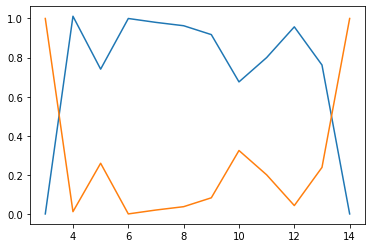

In [89]:
bss_ = findknee(bss)
bss_ = bss_/np.max(bss_)

wss_ = findknee(np.array(pd.DataFrame(wss).mean(1)))
wss_ = wss_/np.max(wss_)

temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)
temp_df.index = np.array(range(0,len(wss_)))+mink
plt.plot(temp_df)

set_ = np.abs(temp_df-1)
plt.plot(set_)
#plt.plot(set_)
optimal_k = np.nanargmin(set_)+mink

print(optimal_k)

In [92]:
clf = KMeansConstrained(n_clusters=optimal_k, size_min=init_min, size_max=max(np.ceil(len(df)/optimal_k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
clf.fit_predict(X_pca)

labels = clf.labels_
clusters = clf.n_clusters
centers = clf.cluster_centers_

within_ss, tot_ss, BSS = deriveANOVA(clf, X_pca)


wss 200.15853753701018
tot_ss 499.9999999999998
bss 299.8414624629896


In [95]:
df['clusters'] = labels

In [96]:
df

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population,clusters
0,Alabama,15.7,9.0,71.0,448,218.2,1.81,22.0,5.0,42666,4634063,3
1,Alaska,8.4,6.9,70.6,661,228.5,1.63,27.3,6.7,68460,679893,4
2,Arizona,14.7,6.4,86.5,483,209.7,1.69,25.1,5.5,50958,6360238,1
3,Arkansas,17.3,8.5,80.8,529,203.4,1.96,18.8,5.1,38815,2841595,3
4,California,13.3,5.0,76.6,523,268.7,1.21,29.6,7.2,61021,36185908,2
5,Colorado,11.4,5.7,89.7,348,259.7,1.14,35.6,4.9,56993,4837229,0
6,Connecticut,9.3,6.2,84.3,256,376.4,0.86,35.6,5.7,68595,3488084,0
7,Delaware,10.0,8.3,74.3,689,250.9,1.23,27.5,4.8,57989,865314,4
8,Florida,13.2,7.3,79.8,723,247.9,1.56,25.8,6.2,47778,18262096,2
9,Georgia,14.7,8.1,65.4,493,217.4,1.46,27.5,6.2,50861,9526642,2
